In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance

#from sklearn.linear_model import Ridge

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [2]:
# If turned on, we'll run some models that take more than 20s seconds to run on a good machine
RUN_HEAVY_MODELS = True

In [3]:
df_master = pd.read_csv("..\\Data_Sets\\processed\\completeData_1995-2022.csv")
df_master.columns

Index(['Country Name', 'Index Year', 'Property Rights', 'Government Integrity',
       'Judicial Effectiveness', 'Government Spending', 'Tax Burden',
       'Fiscal Health', 'Business Freedom', 'Monetary Freedom',
       'Labor Freedom', 'Financial Freedom', 'Investment Freedom',
       'Trade Freedom', 'GDP per capita (current USD)', 'Total population',
       'Gini', 'Inflation CPI', 'Real interest rate', 'Labor force size',
       'Trade (% of GDP)', 'Trade in services (% of GDP)',
       'Under-5 mortality rate (per 1k live births)', 'Country Quintile',
       'isLandLocked', 'n_accessToSea', 'Rail Density',
       'Pctg of Rail Electrified', 'Area Size (km2)', 'Expanded EconZone Area',
       'Amount of Ports', 'Distance from Equator', 'Average Temperature (C)',
       'Death rates from disasters', 'H index (Academic Papers)',
       'Arable Land pct', 'Qualified Labor Force pct',
       'Human Development Index', 'Natural Resources', 'Migration Volume',
       'Harmonized Test Sc

In [4]:
# Converting boolean columns to integer
df_master = df_master.astype({col: 'int' for col in df_master.select_dtypes(['bool']).columns})

# Renaming Economic freedom columns
df_master = df_master.rename(columns={
    'Property Rights':'EF_Property Rights',
    'Government Integrity':'EF_Government Integrity',
    'Judicial Effectiveness':'EF_Judicial Effectiveness',
    'Government Spending':'EF_Government Spending',
    'Tax Burden':'EF_Tax Burden',
    'Fiscal Health':'EF_Fiscal Health',
    'Business Freedom':'EF_Business Freedom',
    'Monetary Freedom':'EF_Monetary Freedom',
    'Labor Freedom':'EF_Labor Freedom',
    'Financial Freedom':'EF_Financial Freedom',
    'Investment Freedom':'EF_Investment Freedom',
    'Trade Freedom':'EF_Trade Freedom'
})

# predictors dataFrame
df_predictors = df_master.iloc[:,2:]
df_predictors = df_predictors.drop(['GDP per capita (current USD)', 'Country Quintile'], axis=1)

# Dealing with Multicollinearity

In [5]:
# Computing correlation matrix
correlation_matrix = df_predictors.corr()

# Identifying pairs of features with high correlation coefficients (greater than 0.7 in absolute value)
highly_correlated_pairs = {}
for col in correlation_matrix.columns:
    for idx in correlation_matrix.index:
        if idx == col:
            continue
        if abs(correlation_matrix.loc[idx, col]) > 0.7:
            pair = tuple(sorted([idx, col]))
            if pair not in highly_correlated_pairs:
                highly_correlated_pairs[pair] = correlation_matrix.loc[idx, col]

# Convert the dictionary to a DataFrame for better display
df_highlyCorrelated = pd.DataFrame(list(highly_correlated_pairs.items()), columns=["Feature Pair", "Correlation Coefficient"])

df_highlyCorrelated

,Feature Pair,Correlation Coefficient
0,"(EF_Government Integrity, EF_Property Rights)",0.848972
1,"(EF_Judicial Effectiveness, EF_Property Rights)",0.713712
2,"(EF_Business Freedom, EF_Property Rights)",0.728501
3,"(EF_Financial Freedom, EF_Investment Freedom)",0.747306
4,"(Human Development Index, Under-5 mortality ra...",-0.864344
5,"(isLandLocked, n_accessToSea)",-0.902937
6,"(Amount of Ports, Expanded EconZone Area)",0.710652
7,"(Amount of Ports, H index (Academic Papers))",0.794973
8,"(Amount of Ports, Migration Volume)",0.764736
9,"(Average Temperature (C), Distance from Equator)",-0.857508


Based on the results above, we'll delete Average Temperature (C), isLandLocked, HDI as they all have more than 0.85 absolute correlation.

There are other high-correlation pairs [like (Government Integrity, Property Rights) and (Amount of Ports, H index (Academic Papers))]. The first one we'll keep as we're trying to predict GDP using mainly Economic Freedom. The later (and others like it) we'll keep as they are from unrelated subjects.

In [6]:
# PS: I've removed both 'Human Development Index' and 'Under-5 mortality rate (per 1k live births)' as they're most likely directly caused by GDP, which distorts our model.
# Feature Selection: A formal verification on all features is necessary (using tests like granger causality tests), after data has been properly transformed to deal with TimeSeries Stationarity.
# This is currently too advanced for me to do properly. So, for now, I'll just use plain common sense.
df_master = df_master.drop(['Average Temperature (C)', 'isLandLocked', 'Human Development Index', 'Under-5 mortality rate (per 1k live births)'], axis=1)

# Normalizing Data

In [7]:
# Selecting only numeric columns (that are not one-hot encoded)
colSelect = list(df_master.columns[2:]) # Excluding Country Name and Index Year
colSelect.remove('Country Quintile')
colSelect.remove('GDP per capita (current USD)')

# Fit and transform the selected numeric columns
df_master[colSelect] = MinMaxScaler().fit_transform(df_master[colSelect])

# Splitting the Data

In [8]:
def dataSplitter(df, quintile = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], splitFactor = 0.8):

    YEAR = int(((2022)-1995)*splitFactor) + 1995

    # Filtering data by quintile
    data_dummies = df.copy().loc[df['Country Quintile'].isin(quintile), :].drop(columns=['Country Quintile', 'Country Name'])

    # Filtering data by target and predictors 
    X = data_dummies.drop(columns=["GDP per capita (current USD)"])
    y = data_dummies[['Index Year',"GDP per capita (current USD)"]]

    # Filtering data by time
    X_train = X.loc[X['Index Year'] <= YEAR].drop(columns=['Index Year'])
    X_test = X.loc[X['Index Year'] > YEAR].drop(columns=['Index Year'])

    y_train = y.loc[y['Index Year'] <= YEAR].drop(columns=['Index Year'])
    y_test = y.loc[y['Index Year'] > YEAR].drop(columns=['Index Year'])

    return X_train, X_test, y_train, y_test

# Regression Models:

### Linear Regression

In [9]:
def linReg_results(df, quintile):
    '''
        Given a quintile (or list of quintiles), returns the result of a linear regression model. 
    '''

    if isinstance(quintile, str):
        quintile = [quintile]

    X_train, X_test, y_train, y_test = dataSplitter(df, quintile)

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    yHat = lr.predict(X_test)

    # Calculate the metrics for the linear model
    linear_mae = mean_absolute_error(y_test, yHat)
    linear_r2 = r2_score(y_test, yHat)

    # Calculate the baseline metrics using mean of y_train as the prediction
    baseline_train_mae = mean_absolute_error(y_train, [y_train.mean()] * len(y_train))
    baseline_test_mae = mean_absolute_error(y_test, [y_train.mean()] * len(y_test))
    baseline_train_r2 = r2_score(y_train, [y_train.mean()] * len(y_train))
    baseline_test_r2 = r2_score(y_test, [y_train.mean()] * len(y_test))

    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        'Metric': ['MAE', 'R^2'],
        'Linear Model (Test)': [linear_mae, linear_r2],
        'Baseline (Train)': [baseline_train_mae, baseline_train_r2],
        'Baseline (Test)': [baseline_test_mae, baseline_test_r2]
    })

    display(str(quintile))

    return display(results_df)

#linReg_results(df_master,'Q1')

# Returning each Quintile, and for all quintiles
for quintile in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']]:
    linReg_results(df_master, quintile)



"['Q1']"

,Metric,Linear Model (Test),Baseline (Train),Baseline (Test)
0,MAE,502.900002,245.310644,640.046081
1,R^2,-0.033117,0.000000,-0.093478


"['Q2']"

,Metric,Linear Model (Test),Baseline (Train),Baseline (Test)
0,MAE,723.523942,747.016214,1179.667613
1,R^2,-0.828157,0.000000,-2.439782


"['Q3']"

,Metric,Linear Model (Test),Baseline (Train),Baseline (Test)
0,MAE,1253.590600,1555.981304,2106.993073
1,R^2,-1.060285,0.000000,-3.042505


"['Q4']"

,Metric,Linear Model (Test),Baseline (Train),Baseline (Test)
0,MAE,2804.441189,3983.385344,4985.942853
1,R^2,0.415253,0.000000,-1.057801


"['Q5']"

,Metric,Linear Model (Test),Baseline (Train),Baseline (Test)
0,MAE,10137.450361,14187.696913,17797.889490
1,R^2,0.591710,0.000000,-0.370383


"['Q1', 'Q2', 'Q3', 'Q4', 'Q5']"

,Metric,Linear Model (Test),Baseline (Train),Baseline (Test)
0,MAE,5576.726022,11499.72397,13128.391513
1,R^2,0.824191,0.00000,-0.034710


### Polynomial Regression

#### Note


I've run this code per for each quintile. Basically, polynominal of 2nd and 3rd order for Q1 through Q4 is horrible. Q5 is decent. When using all quintiles, the model performs even better. Since polynomial is quite heavy to run, I'll only run for 'all quintiles', so it's feasible to do 4th order polynomial.

Results for 3rd order:

##### ORDER NUMBER 3

Q1
| Metric | Polynomial Model (Train) | Polynomial Model (Test) | Baseline (Train) | Baseline (Test) |
|--------|--------------------------|-------------------------|------------------|-----------------|
| MAE    | 1.943297e-16             | 0.005033                | 0.001838         | 0.004795        |
| R^2    | 1.000000e+00             | -0.326713               | 0.000000         | -0.093478       |

Q2
| Metric | Polynomial Model (Train) | Polynomial Model (Test) | Baseline (Train) | Baseline (Test) |
|--------|--------------------------|-------------------------|------------------|-----------------|
| MAE    | 2.903121e-16             | 0.007463                | 0.005596         | 0.008837        |
| R^2    | 1.000000e+00             | -3.332670               | 0.000000         | -2.439782       |

Q3
| Metric | Polynomial Model (Train) | Polynomial Model (Test) | Baseline (Train) | Baseline (Test) |
|--------|--------------------------|-------------------------|------------------|-----------------|
| MAE    | 5.607536e-16             | 0.009312                | 0.011656         | 0.015784        |
| R^2    | 1.000000e+00             | -1.032373               | 0.000000         | -3.042505       |

Q4
| Metric | Polynomial Model (Train) | Polynomial Model (Test) | Baseline (Train) | Baseline (Test) |
|--------|--------------------------|-------------------------|------------------|-----------------|
| MAE    | 1.949839e-15             | 0.031240                | 0.029840         | 0.037351        |
| R^2    | 1.000000e+00             | -1.287932               | 0.000000         | -1.057801       |

Q5
| Metric | Polynomial Model (Train) | Polynomial Model (Test) | Baseline (Train) | Baseline (Test) |
|--------|--------------------------|-------------------------|------------------|-----------------|
| MAE    | 1.437115e-14             | 0.069903                | 0.106283         | 0.133327        |
| R^2    | 1.000000e+00             | 0.517378                | 0.000000         | -0.370383       |

Q1, Q2, Q3, Q4, Q5 Combined
| Metric | Polynomial Model (Train) | Polynomial Model (Test) | Baseline (Train) | Baseline (Test) |
|--------|--------------------------|-------------------------|------------------|-----------------|
| MAE    | 6.183818e-15             | 0.034728                | 0.086146         | 0.098347        |
| R^2    | 1.000000e+00             | 0.882017                | 0.000000         | -0.034710       |

#### Actual Model Pipeline

In [10]:
def poly_regression_results(df, quintile, order, displayResults = True):
    if isinstance(quintile, str):
        quintile = [quintile]
    
    X_train, X_test, y_train, y_test = dataSplitter(df, quintile)
    
    # Create a pipeline with polynomial features and linear regression
    pipeline = Pipeline([
        ('poly_features', PolynomialFeatures(degree=order, include_bias=False)),
        ('lin_reg', LinearRegression())
    ])
    
    # Fit the model to the training data
    pipeline.fit(X_train, y_train)
    
    # Predict on both training and test sets
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # Calculate metrics for training data
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Calculate metrics for test data
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Calculate the baseline metrics using mean of y_train as the prediction
    baseline_train_mae = mean_absolute_error(y_train, [y_train.mean()] * len(y_train))
    baseline_test_mae = mean_absolute_error(y_test, [y_train.mean()] * len(y_test))
    baseline_train_r2 = r2_score(y_train, [y_train.mean()] * len(y_train))
    baseline_test_r2 = r2_score(y_test, [y_train.mean()] * len(y_test))
    
    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        'Metric': ['MAE', 'R^2'],
        'Polynomial Model (Train)': [train_mae, train_r2],
        'Polynomial Model (Test)': [test_mae, test_r2],
        'Baseline (Train)': [baseline_train_mae, baseline_train_r2],
        'Baseline (Test)': [baseline_test_mae, baseline_test_r2]
    })
    if displayResults:
        display(quintile)
        display(results_df)

    return results_df


if RUN_HEAVY_MODELS:
    # Evaluating polynomial model for each quintile
    for order in [2,3,4]:
        display(f'---------------------- ORDER NUMBER {order} ----------------------')
        for quintile in [['Q1', 'Q2', 'Q3', 'Q4', 'Q5']]: # If you want to run for every quintile, use ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']]
            poly_regression_results(df_master, quintile, order=order)

'---------------------- ORDER NUMBER 2 ----------------------'

['Q1', 'Q2', 'Q3', 'Q4', 'Q5']

,Metric,Polynomial Model (Train),Polynomial Model (Test),Baseline (Train),Baseline (Test)
0,MAE,591.418129,4659.948953,11499.72397,13128.391513
1,R^2,0.997426,0.791935,0.00000,-0.034710


'---------------------- ORDER NUMBER 3 ----------------------'

['Q1', 'Q2', 'Q3', 'Q4', 'Q5']

,Metric,Polynomial Model (Train),Polynomial Model (Test),Baseline (Train),Baseline (Test)
0,MAE,9.906884e-10,4635.899614,11499.72397,13128.391513
1,R^2,1.000000e+00,0.882017,0.00000,-0.034710


'---------------------- ORDER NUMBER 4 ----------------------'

['Q1', 'Q2', 'Q3', 'Q4', 'Q5']

,Metric,Polynomial Model (Train),Polynomial Model (Test),Baseline (Train),Baseline (Test)
0,MAE,1.542841e-09,3837.445410,11499.72397,13128.391513
1,R^2,1.000000e+00,0.915027,0.00000,-0.034710


Plotting

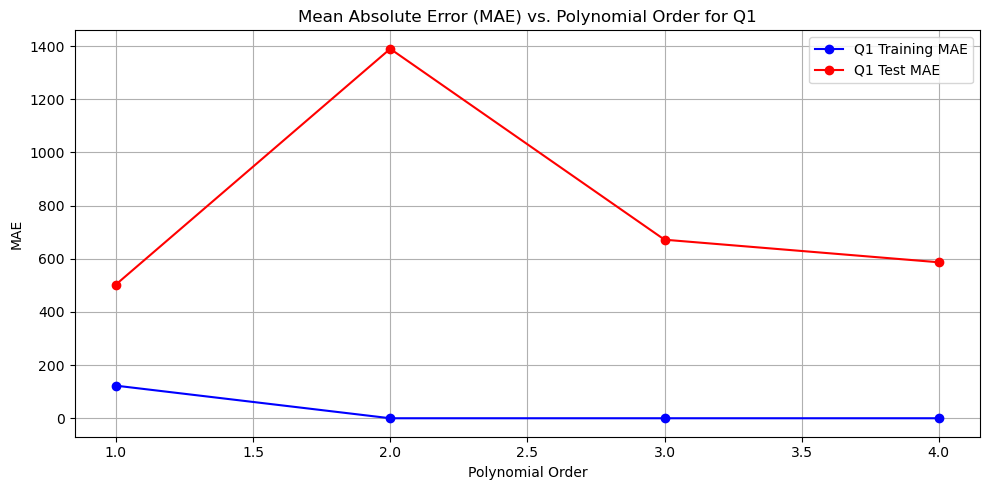

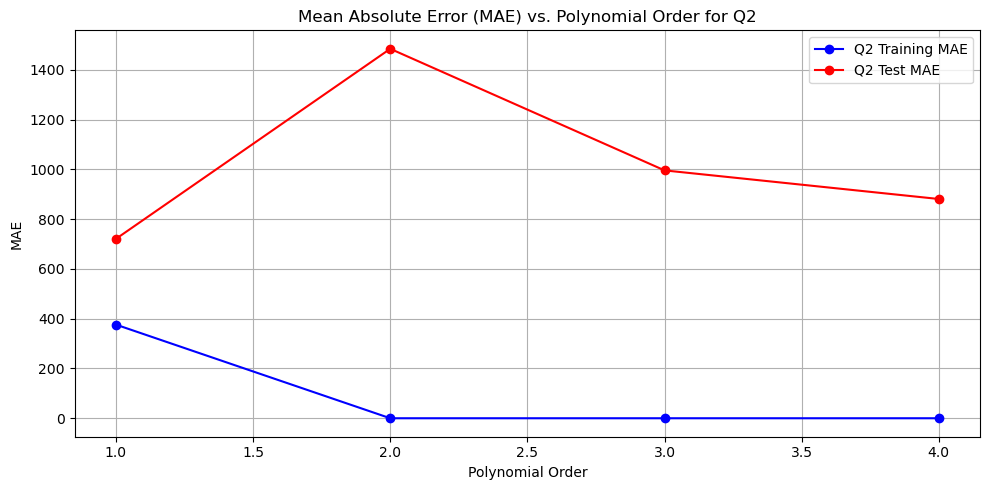

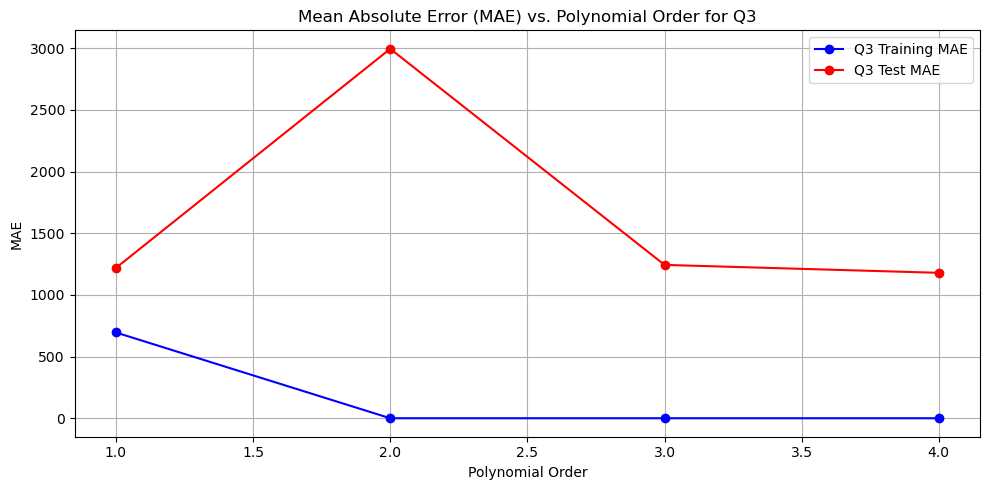

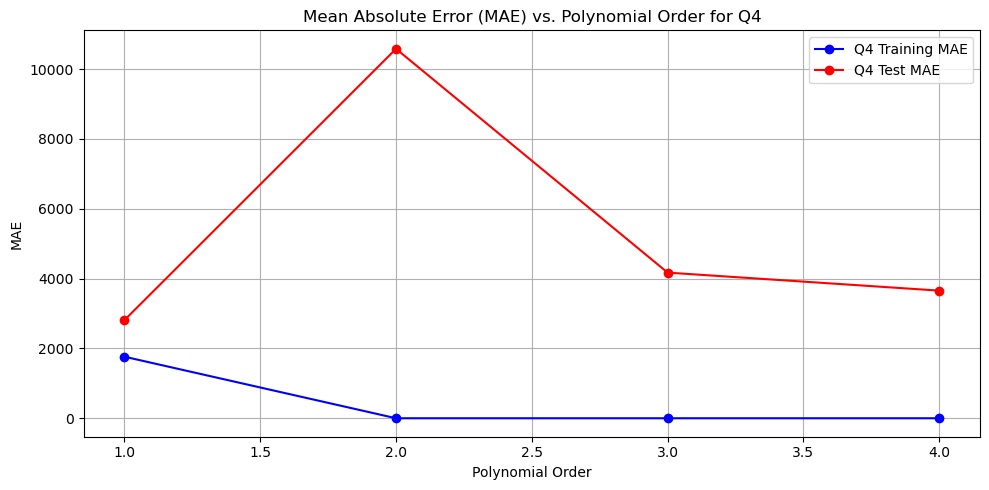

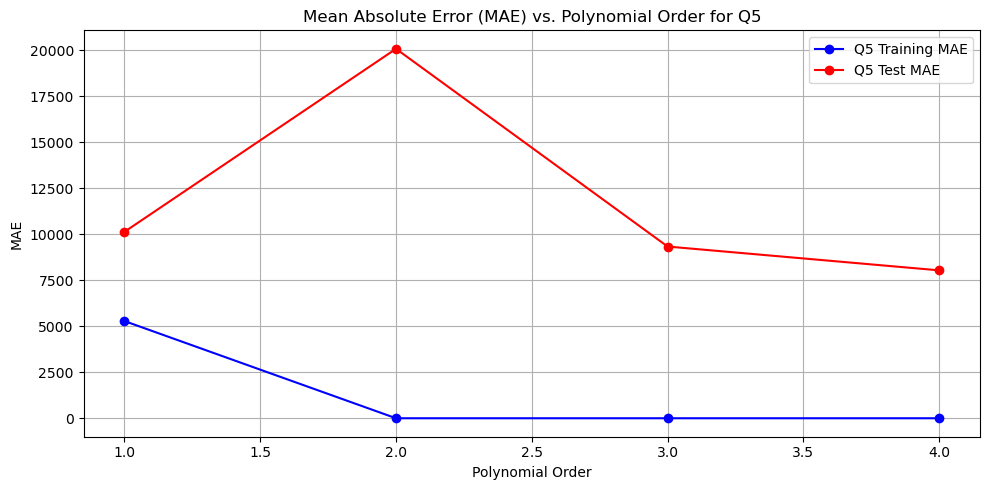

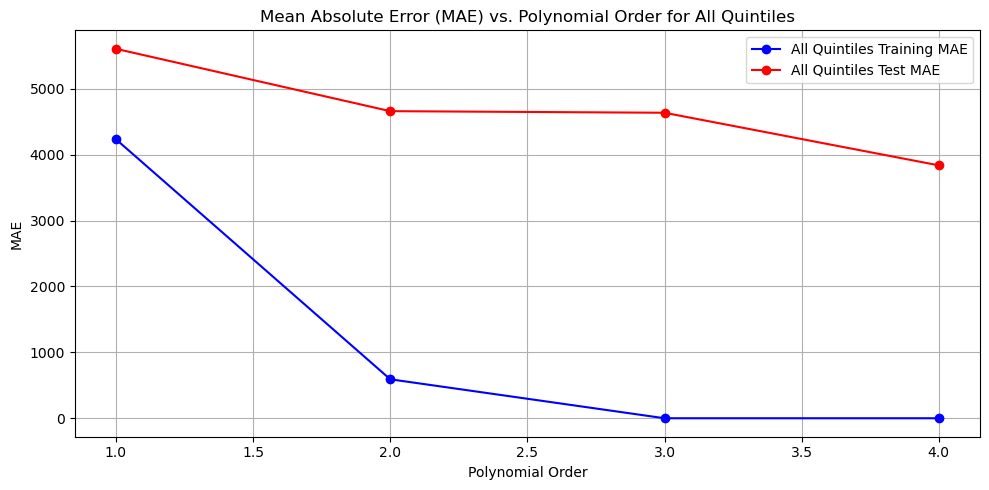

In [11]:
if RUN_HEAVY_MODELS:
    # Initializing a dict to store MAE results
    mae_results = {quintile: {'train': [], 'test': []} for quintile in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'All Quintiles']}
    orders = [1,2,3,4]
    quintiles = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']

    # Loop over polynomial orders
    for order in orders:
        # Evaluate for individual quintiles
        for quintile in quintiles:
            result_df = poly_regression_results(df_master, quintile, order=order, displayResults=False)
            mae_results[quintile]['train'].append(result_df.loc[result_df['Metric'] == 'MAE', 'Polynomial Model (Train)'].values[0])
            mae_results[quintile]['test'].append(result_df.loc[result_df['Metric'] == 'MAE', 'Polynomial Model (Test)'].values[0])
        
        # Evaluate for all quintiles combined after individual quintile evaluations
        result_df_all = poly_regression_results(df_master, quintiles, order=order, displayResults=False)
        mae_results['All Quintiles']['train'].append(result_df_all.loc[result_df_all['Metric'] == 'MAE', 'Polynomial Model (Train)'].values[0])
        mae_results['All Quintiles']['test'].append(result_df_all.loc[result_df_all['Metric'] == 'MAE', 'Polynomial Model (Test)'].values[0])

    # Actual Plotting
    for quintile in mae_results:
        plt.figure(figsize=(10, 5))
        plt.plot(orders, mae_results[quintile]['train'], marker='o', label=f'{quintile} Training MAE', color='blue')
        plt.plot(orders, mae_results[quintile]['test'], marker='o', label=f'{quintile} Test MAE', color='red')

        plt.title(f'Mean Absolute Error (MAE) vs. Polynomial Order for {quintile}')
        plt.xlabel('Polynomial Order')
        plt.ylabel('MAE')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [12]:
# # Results for all quintiles together, and last order polynomial
if RUN_HEAVY_MODELS:
    result_df_all

### KNN Regression

In [13]:
def knn_regression_results(df, quintile, k, displayResults=True):
    if isinstance(quintile, str):
        quintile = [quintile]
    
    # Splitting data
    X_train, X_test, y_train, y_test = dataSplitter(df, quintile)
    
    # Scaling features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize the KNN regressor
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    
    # Fit the KNN regressor on the scaled training data
    knn_regressor.fit(X_train_scaled, y_train)
    
    # Predict on the scaled training and test data
    y_train_pred = knn_regressor.predict(X_train_scaled)
    y_test_pred = knn_regressor.predict(X_test_scaled)
    
    # Calculate metrics
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Baseline metrics (assuming baseline predictions are the average y_train values)
    baseline_train_mae = mean_absolute_error(y_train, [y_train.mean()] * len(y_train))
    baseline_test_mae = mean_absolute_error(y_test, [y_train.mean()] * len(y_test))
    baseline_train_r2 = r2_score(y_train, [y_train.mean()] * len(y_train))
    baseline_test_r2 = r2_score(y_test, [y_train.mean()] * len(y_test))
    
    # Store the results in a DataFrame
    results_df = pd.DataFrame({
        'Metric': ['MAE', 'R^2'],
        'KNN Model (Train)': [train_mae, train_r2],
        'KNN Model (Test)': [test_mae, test_r2],
        'Baseline (Train)': [baseline_train_mae, baseline_train_r2],
        'Baseline (Test)': [baseline_test_mae, baseline_test_r2]
    })
    if displayResults:
        display(quintile)
        display(results_df)

    return results_df

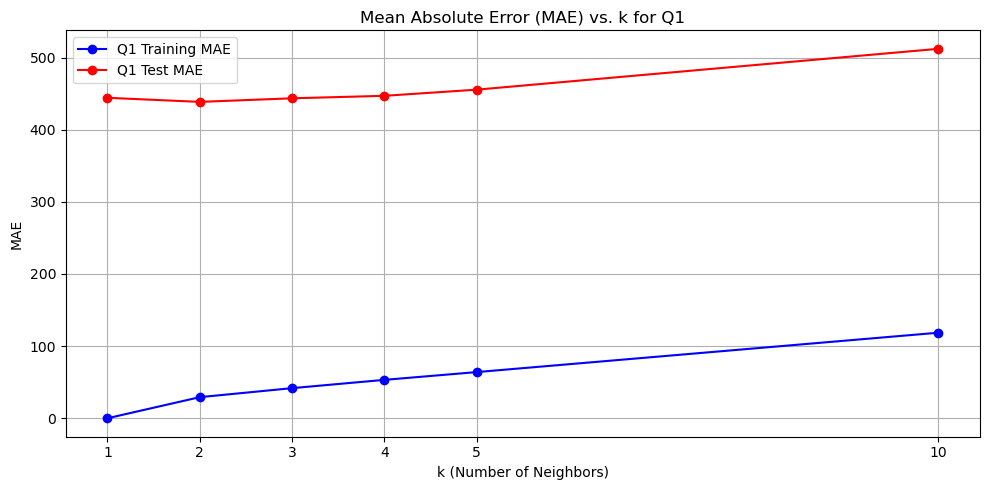

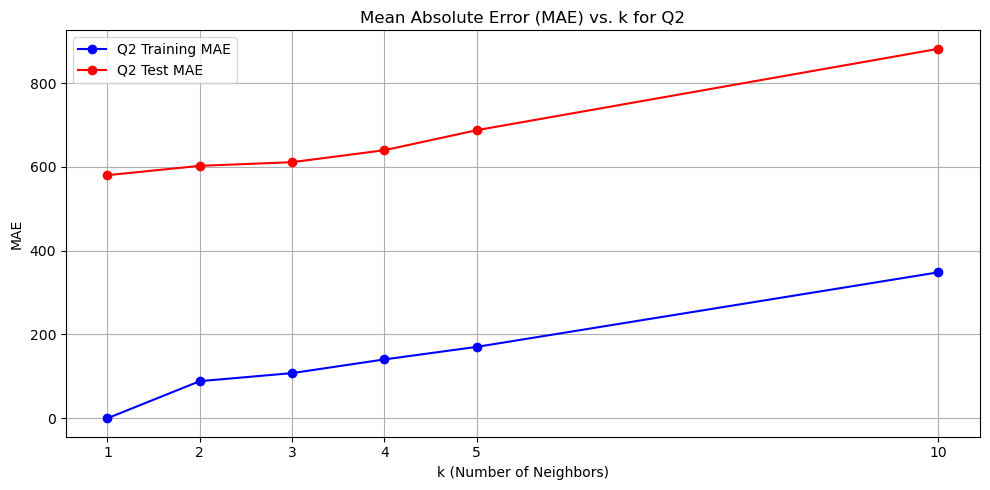

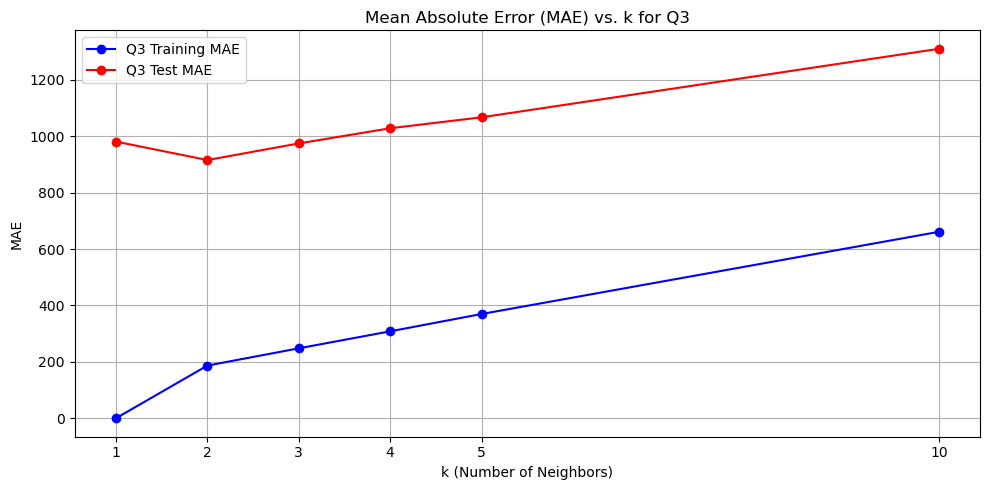

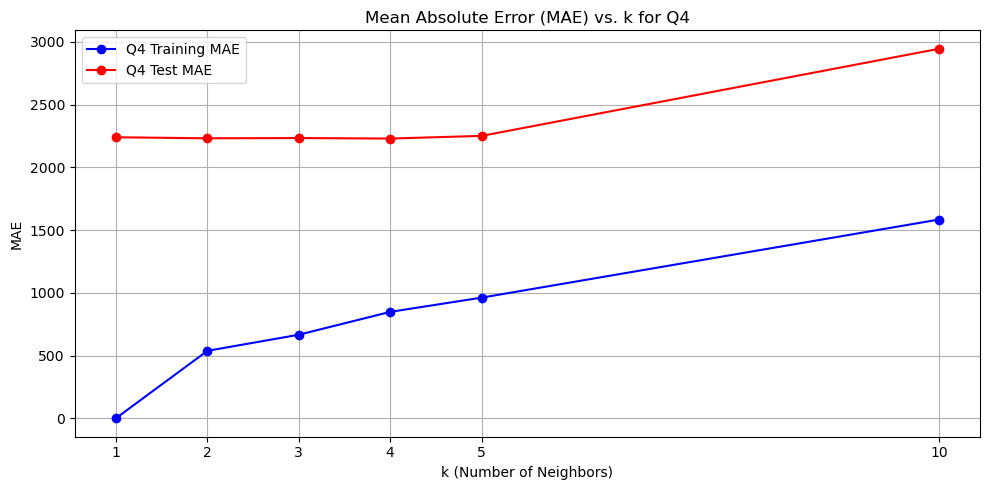

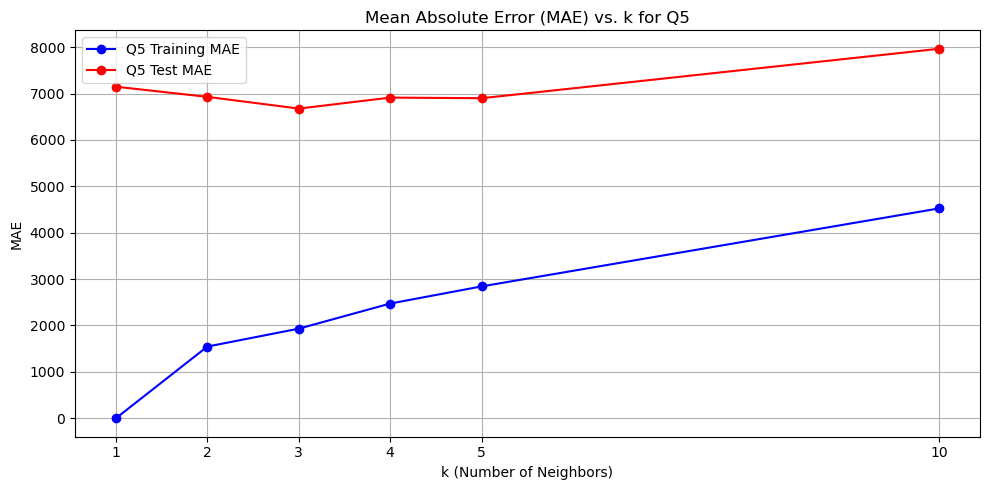

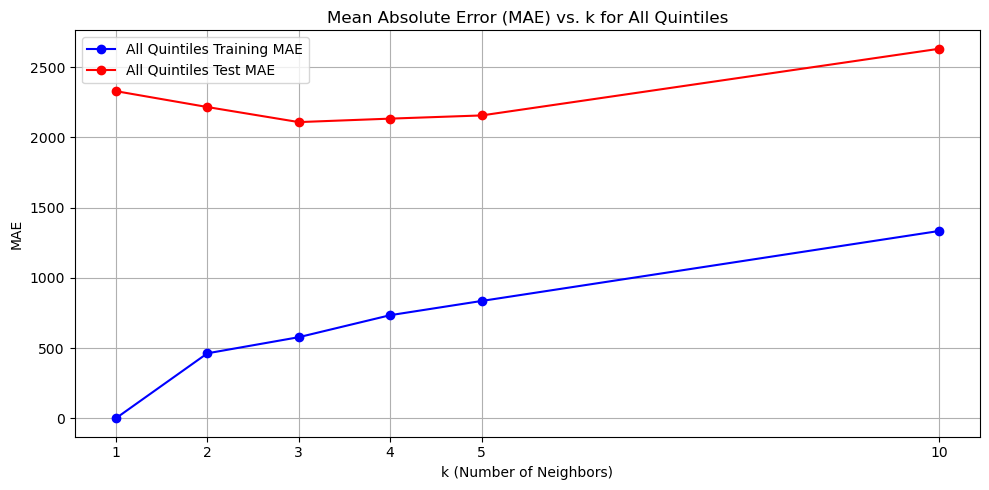

In [14]:
# Initializing a dict to store MAE results
mae_results = {quintile: {'train': [], 'test': []} for quintile in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'All Quintiles']}
k_values = [1, 2, 3, 4, 5, 10]
quintiles = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']

# Loop over KNN k-values
for k in k_values:
    # Evaluate for individual quintiles
    for quintile in quintiles:
        result_df = knn_regression_results(df_master, quintile, k=k, displayResults=False)
        mae_results[quintile]['train'].append(result_df.loc[result_df['Metric'] == 'MAE', 'KNN Model (Train)'].values[0])
        mae_results[quintile]['test'].append(result_df.loc[result_df['Metric'] == 'MAE', 'KNN Model (Test)'].values[0])
    
    # Evaluate for all quintiles combined after individual quintile evaluations
    result_df_all = knn_regression_results(df_master, quintiles, k=k, displayResults=False)
    mae_results['All Quintiles']['train'].append(result_df_all.loc[result_df_all['Metric'] == 'MAE', 'KNN Model (Train)'].values[0])
    mae_results['All Quintiles']['test'].append(result_df_all.loc[result_df_all['Metric'] == 'MAE', 'KNN Model (Test)'].values[0])

# Actual Plotting
for quintile in mae_results:
    # Plotting MAE
    plt.figure(figsize=(10, 5))
    plt.plot(k_values, mae_results[quintile]['train'], marker='o', label=f'{quintile} Training MAE', color='blue')
    plt.plot(k_values, mae_results[quintile]['test'], marker='o', label=f'{quintile} Test MAE', color='red')
    
    plt.title(f'Mean Absolute Error (MAE) vs. k for {quintile}')
    plt.xlabel('k (Number of Neighbors)')
    plt.ylabel('MAE')
    plt.xticks(k_values)  # Set the x-ticks to be the k values
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [15]:
# Best KNN model
knn_regression_results(df_master, ['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], k=3, displayResults=False)

,Metric,KNN Model (Train),KNN Model (Test),Baseline (Train),Baseline (Test)
0,MAE,577.104091,2108.320119,11499.72397,13128.391513
1,R^2,0.993428,0.949188,0.00000,-0.034710


### Regression Tree

Since other models had horrible performance on quintile data, I'll just use the whole data set on this one (while using our split function, of course)

In [16]:
X_train, X_test, y_train, y_test = dataSplitter(df_master)

# Define the hyperparameters and their values
param_grid = {
    'max_features': [12,16,20],
    'max_leaf_nodes': [60,71,75],
    'min_samples_leaf': [1,2],
    'min_samples_split': [2,3,5],
}

# Initialize the regressor
regressor = DecisionTreeRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(regressor, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and associated performance
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

# --------------- Best Parameters --------------------

# ({'max_features': 16,
#   'max_leaf_nodes': 71,
#   'min_samples_leaf': 2,
#   'min_samples_split': 2},
#  -0.03785644629927851)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


({'max_features': 16,
  'max_leaf_nodes': 71,
  'min_samples_leaf': 2,
  'min_samples_split': 2},
 -4889.105570165309)

In [17]:
# Initialize and train the Regression Tree model
reg_tree = DecisionTreeRegressor(random_state=42,max_features= 16,max_leaf_nodes=71,min_samples_leaf=2,min_samples_split=2)
reg_tree.fit(X_train, y_train)

# Predict on the testing set
y_pred = reg_tree.predict(X_test)

# Calculate the mean squared error of the model's predictions
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae, r2

(4346.952813585929, 0.7596906266411544)

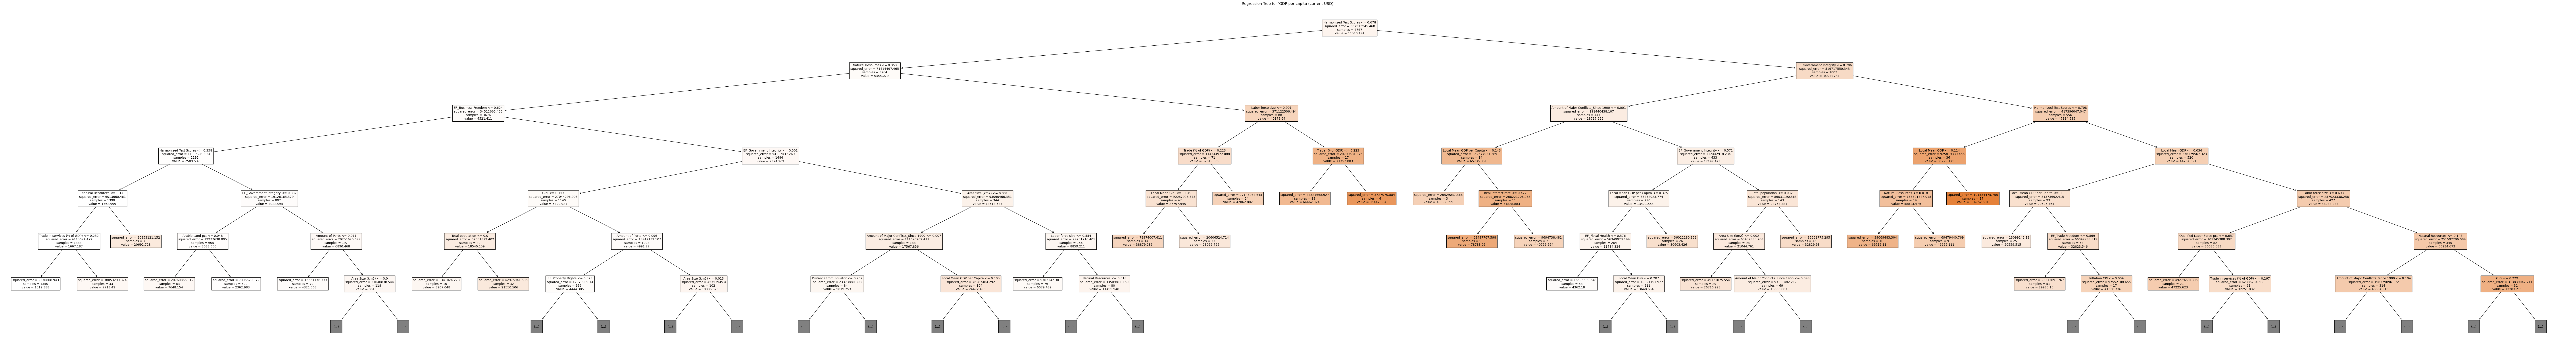

In [18]:
df_regTree = df_master.drop(['Country Name', 'Index Year', 'Country Quintile'], axis=1)

X = df_regTree.drop('GDP per capita (current USD)', axis=1)
y = df_regTree['GDP per capita (current USD)']

# Initialize the DecisionTreeRegressor with the provided parameters
reg_tree = DecisionTreeRegressor(random_state=42, max_features=16, max_leaf_nodes=71,
                                 min_samples_leaf=1, min_samples_split=3)

# Fit the tree
reg_tree.fit(X, y)

# Plotting the tree
# Convert X.columns to a list and plot the tree
plt.figure(figsize=(150, 20))
plot_tree(reg_tree, max_depth=6, feature_names=list(X.columns), filled=True, fontsize=10)

plt.title("Regression Tree for 'GDP per capita (current USD)'")
plt.show()

#### Quantifying Feature Importance
[discontinued code]

if 1 + 1 == 3:
    # We won't run this feature importance code,
    # as Regression Tree wasn't the best model for predicting our target variable.

    # I've left it here just so if anyone would like to run it

    from collections import defaultdict

    # Extract the tree attributes
    tree_attributes = reg_tree.tree_
    tree_depth = reg_tree.get_depth()

    # Initialize counters for features and scores
    feature_counts = defaultdict(int)
    feature_scores = defaultdict(int)

    def compute_node_depth(tree):
        """Compute the depth of each node in the decision tree."""
        left_child = tree.children_left
        right_child = tree.children_right

        # Array to hold the depth level of each node
        node_depth = np.zeros(shape=tree.node_count, dtype=np.int64)
        
        # Seed is the root node id and its depth
        stack = [(0, -1)]
        
        while len(stack) > 0:
            node_id, parent_depth = stack.pop()
            node_depth[node_id] = parent_depth + 1

            # Append child nodes to the stack
            if left_child[node_id] != right_child[node_id]:  # Check if node is not a leaf
                stack.append((left_child[node_id], parent_depth + 1))
                stack.append((right_child[node_id], parent_depth + 1))
                
        return node_depth

    # Get the depth of each node
    node_depths = compute_node_depth(tree_attributes)

    # Reset counters for features and scores
    feature_counts = defaultdict(int)
    feature_scores = defaultdict(int)

    # Calculate the feature counts and scores
    for depth, feature_index in zip(node_depths, tree_attributes.feature):
        if feature_index >= 0:  # Check for non-leaf nodes
            feature_name = X.columns[feature_index]
            feature_counts[feature_name] += 1
            
            # Calculate score based on depth
            score_increment = (tree_depth - depth)*depth/10 # give more weight to early features
            feature_scores[feature_name] += score_increment

    # Convert the dictionaries to sorted lists for clearer presentation
    sorted_feature_counts = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_feature_scores = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

    # Convert the sorted feature counts and scores to dataframes
    df_feature_counts = pd.DataFrame(sorted_feature_counts, columns=['Feature', 'Count'])
    df_feature_scores = pd.DataFrame(sorted_feature_scores, columns=['Feature', 'Score'])
